In [1]:
pip install sentence-transformers faiss-cpu transformers diskcache termcolor matplotlib lime


Note: you may need to restart the kernel to use updated packages.


    click (>=7.0<=8.1.*)
          ~~~~~~^

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install langdetect


Note: you may need to restart the kernel to use updated packages.


    click (>=7.0<=8.1.*)
          ~~~~~~^

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install ollama


Note: you may need to restart the kernel to use updated packages.


    click (>=7.0<=8.1.*)
          ~~~~~~^

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install flask

Note: you may need to restart the kernel to use updated packages.


    click (>=7.0<=8.1.*)
          ~~~~~~^

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import ollama
from sentence_transformers import SentenceTransformer
import faiss
import json
from langdetect import detect
import diskcache as dc
from termcolor import colored
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer

# ✅ Chargement des données JSON
with open('C:/Users/Emna Nkhili/Desktop/RAG-Project/data/cleaned_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# ✅ Extraction des phrases valides
sentences = [item['content'] for item in data if 'content' in item and item['content'].strip()]
if not sentences:
    raise ValueError("Aucune phrase valide trouvée dans le fichier JSON.")

# ✅ Encodage des phrases
embedder = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedder.encode(sentences, convert_to_tensor=False)

# ✅ Création d'un index FAISS
embedding_dim = len(embeddings[0])
index = faiss.IndexFlatL2(embedding_dim)
index.add(np.array(embeddings).astype('float32'))

# ✅ Vérification de la connexion à Ollama
print("🔄 Vérification de la connexion à Ollama...")
try:
    ollama.chat(model="mistral:latest", messages=[{'role': 'user', 'content': 'Test de connexion'}])
    print("✅ Connexion réussie à Ollama.")
except Exception as e:
    print("❌ Erreur de connexion à Ollama :", e)
    exit()

# ✅ Mise en cache des résultats
cache = dc.Cache('C:/Users/Emna Nkhili/Desktop/RAG-Project/data/cache_directory')

# ✅ Fonction principale
def generate_answer_with_xai(user_query, top_k=5):
    lang = detect(user_query)
    lang = 'fr' if lang == 'fr' else 'en'
    cache_key = f"{lang}_{user_query.strip().lower()}"

    if cache_key in cache:
        print("✅ Réponse récupérée depuis le cache.\n")
        return cache[cache_key]

    # Embedding de la requête
    query_embedding = embedder.encode([user_query], convert_to_tensor=False)
    distances, indices = index.search(np.array(query_embedding).astype('float32'), top_k)

    matched_phrases = [sentences[idx] for idx in indices[0]]
    similarity_scores = distances[0]

    print("\n🎯 Top phrases sélectionnées pour le contexte :")
    for i, (phrase, score) in enumerate(zip(matched_phrases, similarity_scores)):
        color = 'green' if score < 0.4 else 'yellow' if score < 0.8 else 'red'
        print(f"[{i+1}] ({score:.2f}) {colored(phrase.strip(), color)}")

    context = "\n".join(matched_phrases)

    # Création du prompt pour Ollama
    full_prompt = (
        f"Tu es un vétérinaire expert en remèdes naturels pour animaux domestiques.\n\n"
        f"Voici quelques exemples de traitements :\n{context}\n\n"
        f"Sur cette base, réponds à la question suivante :\n{user_query}"
        if lang == 'fr' else
        f"You are a veterinarian expert in natural pet remedies.\n\n"
        f"Here are some examples:\n{context}\n\n"
        f"Based on this, answer the question:\n{user_query}"
    )

    print("\n📨 Prompt envoyé à Ollama :\n" + "-"*60)
    print(full_prompt)
    print("-"*60)

    # Envoi du prompt à Ollama
    response = ollama.chat(
        model="mistral:latest",
        messages=[{'role': 'user', 'content': full_prompt}]
    )

    # Fonction prédictive LIME (basée sur la similarité)
    def lime_predict(texts):
        preds = []
        for txt in texts:
            emb = embedder.encode([txt], convert_to_tensor=False)
            dists, _ = index.search(np.array(emb).astype('float32'), top_k)
            sim = -dists[0]
            preds.append([sim.mean(), 1 - sim.mean()])
        return np.array(preds)

    # Explication LIME
    explainer = LimeTextExplainer(class_names=['irrelevant', 'relevant'])
    exp = explainer.explain_instance(user_query, lime_predict, num_features=8)

    print("\n🧠 Influence des mots dans la requête (LIME) :")
    for word, weight in exp.as_list():
        print(f"{word}: {weight:.3f}")

    # Affichage graphique LIME
    fig = exp.as_pyplot_figure()
    plt.title("Influence des mots de la requête selon LIME")
    plt.tight_layout()
    plt.show()

    # Mise en cache
    final_response = {
        "response": response['message']['content'],
        "context_used": matched_phrases,
        "distances": similarity_scores.tolist(),
        "prompt": full_prompt,
        "lime_weights": exp.as_list()
    }
    cache[cache_key] = final_response
    return final_response

# ✅ Exemple d'exécution
if __name__ == "__main__":
    question = "Quels remèdes naturels contre les vomissements chez le chat ?"
    result = generate_answer_with_xai(question)

    print("\n💬 Réponse générée :")
    print(result["response"])


🔄 Vérification de la connexion à Ollama...


KeyboardInterrupt: 

c:\Users\Emna Nkhili\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 Vérification de la connexion à Ollama...
✅ Connexion réussie à Ollama

🎯 Top phrases sélectionnées pour le contexte :
[1] (1.32) Herbs for Pets SECOND EDITION The natural way to enhance your pet’s life by Gregory L. Tilford & Mary L. Wulff SECOND EDITION • Care for Senior Animals • Anxiety and Behavior Concerns A HOLISTIC GUIDE TO Herbs forPets • Cancer and Other Health Issues • Parasite Prevention and Treatment • Diet and Nutrition Supplements Tilford/ Wulff SECOND EDITION Herbs forPets Text copyright © 2009 by Gregory Tilford and Mary Wulff Photographs copyright © 2009 by Gregory Tilford Additional photographs courtesy of: Isabelle Francais/BowTie Inc. and Tara Darling; cover, Tara Darling (cat), Lesley Ward (horse), and Karen Taylor (dog) All rights reserved. No part of this book may be reproduced, stored in a retrieval sys- tem, or transmitted in any form or by any means, electronic, mechanical, photocopy- ing, recording, or otherwise, without the prior written permission of BowT

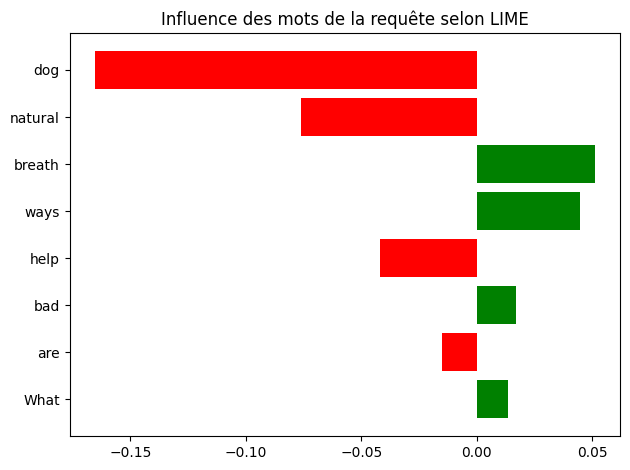


💬 Réponse générée :
Bad breath in dogs! As a veterinarian expert in natural pet remedies, I'd be happy to help you with that.

Firstly, it's essential to identify the underlying cause of your dog's bad breath. Common culprits include:

1. Poor dental care or gum disease
2. Gum inflammation (gingivitis)
3. Kidney disease
4. Liver disease
5. Respiratory infections
6. Inadequate digestion and gut health

Now, let's explore some natural ways to help alleviate your dog's bad breath:

**Herbal Remedies:**

1. **Neem powder**: Mix 1/4 teaspoon of neem powder with your dog's food or add it to their favorite treats.
2. **Tulsi (Holy Basil)**: Add a few leaves of tulsi to your dog's food or use as a tea substitute.

**Dental Care:**

1. **Brushing**: Use a dog-specific toothbrush and natural dog toothpaste to clean your dog's teeth daily.
2. **Raw Bones**: Provide raw, uncooked bones (e.g., knucklebones) for your dog to chew on. This helps remove plaque and tartar from their teeth.
3. **Dental 

In [5]:
import numpy as np
import ollama
from sentence_transformers import SentenceTransformer
import faiss
import json
from langdetect import detect
import diskcache as dc
from termcolor import colored
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer

# Chargement des données JSON
with open('C:/Users/Emna Nkhili/Desktop/RAG-Project/data/cleaned_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extraction des phrases valides
sentences = [item['content'] for item in data if 'content' in item and item['content'].strip()]
if not sentences:
    raise ValueError("Aucune phrase valide trouvée.")

# Encodage des phrases
embedder = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedder.encode(sentences, convert_to_tensor=False)

# Création d'un index FAISS pour la recherche
embedding_dim = len(embeddings[0])
index = faiss.IndexFlatL2(embedding_dim)
index.add(np.array(embeddings).astype('float32'))

# Vérification de la connexion à Ollama
print("🔄 Vérification de la connexion à Ollama...")
try:
    ollama.chat(model="llama3", messages=[{'role': 'user', 'content': 'Test connexion'}])
    print("✅ Connexion réussie à Ollama")
except Exception as e:
    print("❌ Erreur de connexion à Ollama :", e)
    exit()

# Cache pour éviter les recalculs
cache = dc.Cache('C:/Users/Emna Nkhili/Desktop/RAG-Project/data/cache_directory')

# Fonction principale avec explication LIME
def generate_answer_with_xai(user_query, top_k=5):
    lang = detect(user_query)
    lang = 'fr' if lang == 'fr' else 'en'
    cache_key = f"{lang}_{user_query.strip().lower()}"

    if cache_key in cache:
        print("✅ Réponse récupérée depuis le cache.\n")
        return cache[cache_key]

    # Embedding de la requête
    query_embedding = embedder.encode([user_query], convert_to_tensor=False)
    distances, indices = index.search(np.array(query_embedding).astype('float32'), top_k)

    matched_phrases = [sentences[idx] for idx in indices[0]]
    similarity_scores = distances[0]

    # Affichage des phrases contextuelles
    print("\n🎯 Top phrases sélectionnées pour le contexte :")
    for i, (phrase, score) in enumerate(zip(matched_phrases, similarity_scores)):
        if score < 0.4:
            color = 'green'
        elif score < 0.8:
            color = 'yellow'
        else:
            color = 'red'
        print(f"[{i+1}] ({score:.2f}) {colored(phrase.strip(), color)}")

    context = "\n".join(matched_phrases)

    # Création du prompt
    full_prompt = (
        f"Tu es un vétérinaire expert en remèdes naturels pour animaux domestiques.\n\n"
        f"Voici quelques exemples de traitements :\n{context}\n\n"
        f"Sur cette base, réponds à la question suivante :\n{user_query}"
        if lang == 'fr' else
        f"You are a veterinarian expert in natural pet remedies.\n\n"
        f"Here are some examples:\n{context}\n\n"
        f"Based on this, answer the question:\n{user_query}"
    )

    # Affichage du prompt complet
    print("\n📨 Prompt envoyé à Ollama :\n" + "-"*60)
    print(full_prompt)
    print("-"*60)

    # Appel Ollama
    response = ollama.chat(
        model="llama3",
        messages=[{'role': 'user', 'content': full_prompt}]
    )

    # 🧠 Fonction pour LIME : mesurer la similarité moyenne
    def lime_predict(texts):
        preds = []
        for txt in texts:
            emb = embedder.encode([txt], convert_to_tensor=False)
            dists, _ = index.search(np.array(emb).astype('float32'), top_k)
            sim = -dists[0]
            preds.append([sim.mean(), 1 - sim.mean()])
        return np.array(preds)

    # 🧪 Explication avec LIME
    explainer = LimeTextExplainer(class_names=['irrelevant', 'relevant'])
    exp = explainer.explain_instance(user_query, lime_predict, num_features=8)

    print("\n🧠 Influence des mots dans la requête (LIME) :")
    for word, weight in exp.as_list():
        print(f"{word}: {weight:.3f}")

    # 🔍 Affichage graphique
    fig = exp.as_pyplot_figure()
    plt.title("Influence des mots de la requête selon LIME")
    plt.tight_layout()
    plt.show()

    # Enregistrement du résultat dans le cache
    final_response = {
        "response": response['message']['content'],
        "context_used": matched_phrases,
        "distances": similarity_scores.tolist(),
        "prompt": full_prompt,
        "lime_weights": exp.as_list()
    }
    cache[cache_key] = final_response
    return final_response

# Exemple de question
question = "My dog has bad breath. What are some natural ways to help?"
result = generate_answer_with_xai(question)

print("\n💬 Réponse générée :")
print(result["response"])



🎯 Top phrases sélectionnées pour le contexte :
[1] (1.27) LES CENELLES (BAIES D’AUBEPINES) UN EXCELLENT TONIQUE CARDIAQUE ET UN RELAXANT - Site de vismedicatrixnaturae ! La nature est guerisseuse - Remedes naturels pour chiens et chats ACCUEILA PROPOS DE NOUSSANTE GENERALEDOSSIER VACCINATIONLES TAUTODES : UNE SOLUTION NATURELLE A LA VACCINOSELES NOSODES : UNE ALTERNATIVE AUX VACCINS...PROTOCOLE HOMEOPATHIQUE PRÉ ET POST VACCINATIONA QUELLE FREQUENCE FAIRE LES RAPPELS DE VACCINS CHEZ VOS ANIMAUX DE COMPAGNIE?Vous voulez détoxifier une vaccination ?POURQUOI LES VETERINAIRES S'EN TIRENT A BON COMPTE5 CHOSES QUE DIT VOTRE VETERINAIRE ET QUI NE SONT PAS VRAIESOTER LE DANGER DES VACCINS CHEZ LES CHIOTSLA LEPTO : SACHEZ QUELS SONT LES RISQUES POUR VOTRE CHIENLa Leptospirose Chez Le Chien : Pourquoi le Vaccin Ne Marche PasEffets indésirables des vaccins en médecine vétérinaireLE VACCIN CONTRE LA MALADIE DE CARRRE : COMMENT LES VETERIAIRES FONT FAUSSE ROUTECHIENS ET CHATS EN SURPOIDS : LES RIS

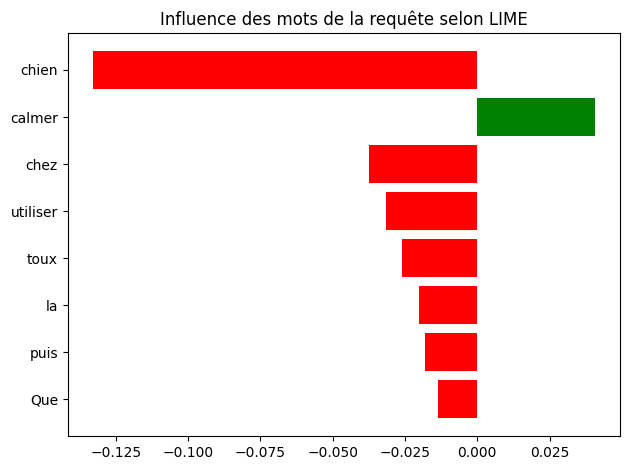

✅ Réponse récupérée depuis le cache.

🔵 Réponse du modèle Mistral :
Bonjour !

Selon les remèdes naturels que je vous recommande, pour calmer la toux chez un chien, voici quelques options :

1. **Teinture mère d'olive** : Vous pouvez utiliser 1 goutte de teinture mère d'olive (préparée suivant les instructions données plus haut) par 3kg de poids corporel du chien, une fois par jour. Vous pouvez la diluer avec un peu de water ou de lait si le goût est trop fort pour votre chien.
2. **Gelule d'olive** : Si vous préférez utiliser des gelules, vous pouvez donner 1/4 à 1/2 gélule par 3kg de poids corporel du chien, une fois par jour. Assurez-vous que les gelules sont fabriquées avec des feuilles d'olive fraîches et non séchées.
3. **Huile d'olive** : Vous pouvez également utiliser de l'huile d'olive pure (sans additifs ni aromas) pour calmer la toux de votre chien. Ajoutez 1 à 2 cuillères à soupe d'huile d'olive dans sa nourriture ou buvez-la avec lui. Cependant, assurez-vous que l'huile es

In [8]:
# Exemple de fonction pour évaluer et comparer les sorties des deux modèles
def compare_models(question):
    # Utilisation du modèle Mistral
    result_mistral = generate_answer_with_xai(question)
    response_mistral = result_mistral["response"]
    
    # Utilisation du modèle Llama3
    result_llama3 = generate_answer_with_xai(question)
    response_llama3 = result_llama3["response"]

    # Affichage des réponses des deux modèles
    print(f"🔵 Réponse du modèle Mistral :\n{response_mistral}")
    print("-" * 60)
    print(f"🟢 Réponse du modèle Llama3 :\n{response_llama3}")
    
    # Comparaison basique de la longueur des réponses
    print("\nLongueur des réponses :")
    print(f"Modèle Mistral : {len(response_mistral)} caractères")
    print(f"Modèle Llama3 : {len(response_llama3)} caractères")
    
    # Comparaison des distances LIME (moyenne des poids)
    lime_weights_mistral = np.mean([weight for _, weight in result_mistral["lime_weights"]])
    lime_weights_llama3 = np.mean([weight for _, weight in result_llama3["lime_weights"]])
    
    print("\nMoyenne des poids LIME :")
    print(f"Modèle Mistral : {lime_weights_mistral:.3f}")
    print(f"Modèle Llama3 : {lime_weights_llama3:.3f}")
    
    # Affichage des différences de scores (si nécessaire)
    return response_mistral, response_llama3

# Test avec une question
question = "Que puis-je utiliser pour calmer la toux chez un chien ?"
response_mistral, response_llama3 = compare_models(question)


In [12]:

    # Exemple de question
question = "Quels sont les remèdes naturels pour les puces chez le chien ?"

result = generate_answer_with_xai(question)

print("\n💬 Réponse générée :")
print(result["response"])



🎯 Top phrases sélectionnées pour le contexte :
[1] (1.09) LA PASTEQUE : UNE EXCELLENTE ADDITION A L’ALIMENTATION DE VOTRE CHIEN - Site de vismedicatrixnaturae ! La nature est guerisseuse - Remedes naturels pour chiens et chats ACCUEILA PROPOS DE NOUSSANTE GENERALEDOSSIER VACCINATIONLES TAUTODES : UNE SOLUTION NATURELLE A LA VACCINOSELES NOSODES : UNE ALTERNATIVE AUX VACCINS...PROTOCOLE HOMEOPATHIQUE PRÉ ET POST VACCINATIONA QUELLE FREQUENCE FAIRE LES RAPPELS DE VACCINS CHEZ VOS ANIMAUX DE COMPAGNIE?Vous voulez détoxifier une vaccination ?POURQUOI LES VETERINAIRES S'EN TIRENT A BON COMPTE5 CHOSES QUE DIT VOTRE VETERINAIRE ET QUI NE SONT PAS VRAIESOTER LE DANGER DES VACCINS CHEZ LES CHIOTSLA LEPTO : SACHEZ QUELS SONT LES RISQUES POUR VOTRE CHIENLa Leptospirose Chez Le Chien : Pourquoi le Vaccin Ne Marche PasEffets indésirables des vaccins en médecine vétérinaireLE VACCIN CONTRE LA MALADIE DE CARRRE : COMMENT LES VETERIAIRES FONT FAUSSE ROUTECHIENS ET CHATS EN SURPOIDS : LES RISQUES POUR

In [6]:
from flask import Flask, request, jsonify
import numpy as np
import json
from sentence_transformers import SentenceTransformer
import faiss
from langdetect import detect
import diskcache as dc
import ollama

app = Flask(__name__)

# Chargement du modèle
embedder = SentenceTransformer('all-MiniLM-L6-v2')
with open('C:/Users/Emna Nkhili/Desktop/RAG-Project/data/cleaned_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extraction des phrases
sentences = [item['content'] for item in data if 'content' in item and item['content'].strip()]
embeddings = embedder.encode(sentences, convert_to_tensor=False)
embedding_dim = len(embeddings[0])
index = faiss.IndexFlatL2(embedding_dim)
index.add(np.array(embeddings).astype('float32'))

# Initialisation du cache
cache = dc.Cache('C:/Users/Emna Nkhili/Desktop/RAG-Project/data/cache_directory')

# Fonction pour générer une réponse
def generate_answer(user_query, top_k=5):
    lang = detect(user_query)
    lang = 'fr' if lang == 'fr' else 'en'
    cache_key = f"{lang}_{user_query.strip().lower()}"

    if cache_key in cache:
        return cache[cache_key]

    query_embedding = embedder.encode([user_query], convert_to_tensor=False)
    distances, indices = index.search(np.array(query_embedding).astype('float32'), top_k)
    matched_phrases = [sentences[idx] for idx in indices[0]]
    context = "\n".join(matched_phrases)

    if lang == 'fr':
        full_prompt = f"""Tu es un vétérinaire expert en remèdes naturels pour les animaux domestiques.
Voici des exemples :
{context}

En te basant sur ces informations, réponds à la question suivante :
Question : {user_query}
"""
    else:
        full_prompt = f"""You are a veterinarian expert in natural remedies for pets.
Here are some examples:
{context}

Based on this information, answer the following question:
Question: {user_query}
"""

    response = ollama.chat(
        model="llama3-gpu",
        messages=[{'role': 'user', 'content': full_prompt}]
    )

    cache[cache_key] = response['message']['content']
    return response['message']['content']

# Route API
@app.route('/generate_answer', methods=['GET', 'POST'])
def api_generate_answer():
    if request.method == 'GET':
        return jsonify({'message': 'Use POST method with a question in JSON body.'})
    
    data = request.get_json()
    question = data.get('question', '')
    if not question:
        return jsonify({'error': 'Question not provided'}), 400
    answer = generate_answer(question)
    return jsonify({'answer': answer})


# Lancement de l'application Flask
if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)  # 🔧 use_reloader=False empêche le redémarrage automatique


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/May/2025 22:48:59] "POST /generate_answer HTTP/1.1" 200 -
127.0.0.1 - - [11/May/2025 22:51:15] "POST /generate_answer HTTP/1.1" 200 -
127.0.0.1 - - [11/May/2025 22:54:39] "POST /generate_answer HTTP/1.1" 200 -
127.0.0.1 - - [11/May/2025 22:55:28] "POST /generate_answer HTTP/1.1" 200 -
127.0.0.1 - - [11/May/2025 22:57:17] "POST /generate_answer HTTP/1.1" 200 -
127.0.0.1 - - [11/May/2025 22:58:02] "POST /generate_answer HTTP/1.1" 200 -
